In [ ]:
# default_exp ocr_crnn_training

In [ ]:
#export
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#export
from ocr.core import save_inference, load_inference
from ocr.ocr_dataset_fontsynth import create_df as create_fontsynth_df
from ocr.ocr_dataset_sroie2019 import create_df as create_sroie_df
from ocr.ocr_dataset_brno import create_df as create_brno_df
from ocr.ocr_dataset_sroie2019 import sroie_ocr_config, DATA_PATH, char_freq
from ocr.ocr_dataset_fontsynth import fontsynth_config, char_freq
from ocr.ocr_dataset_brno import brno_ocr_config
PAD = sroie_ocr_config.PAD # PAD - how much is data padded
PAD = 0
DATA_PATH = fontsynth_config.LINES_DIR

In [ ]:
# assert DATA_PATH == os.path.join('../data/ocr/lines')

In [ ]:
#export
allowed_chars = {'N', '3', 'V', 'P', '7', '1', '#', '9', '"', 'C', 'Q', 'B', 'E', '>', '@', ',', 'M', '{', ']', 
                 ';', '^', "'", '&', '6', 'Z', '*', '<', '+', 'G', 'X', '!', ':', '-', '[', '|', '$', '5', 'I', 
                 'H', '=', 'Y', '.', 'R', 'S', '/', 'T', '}', 'K', '0', '?', 'U', ')', '_', 'D', 'J', 'L', '4', 
                 'W', '%', '(', ' ', 'F', '8', '~', '\\', 'A', '2', 'O'}

allowed_chars = fontsynth_config.allowed_chars

allowed_fonts = ['Unknown', 'Andale_Mono', 'Arial', 'Arial_Black', 'Arial_Bold', 'Arial_Bold_Italic', 'Arial_Italic',
'Comic_Sans_MS_Bold', 'Courier_New', 'Courier_New_Bold', 'Courier_New_Bold_Italic', 'Courier_New_Italic',
'Georgia', 'Georgia_Bold', 'Georgia_Bold_Italic', 'Georgia_Italic', 'Impact', 'Times_New_Roman',
'Times_New_Roman_Bold', 'Times_New_Roman_Bold_Italic', 'Times_New_Roman_Italic', 'Trebuchet_MS',
'Trebuchet_MS_Bold', 'Trebuchet_MS_Bold_Italic', 'Trebuchet_MS_Italic', 'Verdana', 'Verdana_Bold',
'Verdana_Bold_Italic', 'Verdana_Italic', 'brno_easy', 'brno_medium', 'sroie2019', 'Comic_Sans_MS']

class crnn_config:
    LINE_HEIGHT = 48
    USE_DEFAULT_CLASSES = True
    label_delim = '`'
    pad_idx = 0 # aka: label_delim idx
    allowed_chars = allowed_chars
    allowed_fonts = allowed_fonts

### Prep

In [ ]:
print(char_freq)

{'`': 3, '$': 3, '&': 4, 'Q': 7, ']': 14, '[': 17, '*': 19, '?': 19, '~': 27, '|': 29, 'q': 32, '!': 36, 'Ū': 42, '>': 65, '<': 67, 'Y': 80, '_': 80, 'Z': 82, 'x': 105, '+': 111, 'Į': 118, '=': 124, 'W': 126, '/': 131, "'": 136, 'w': 158, 'Č': 172, 'U': 202, ';': 236, '%': 481, 'Ž': 485, 'F': 503, 'O': 510, 'C': 524, 'H': 563, '-': 816, ':': 921, 'Š': 1024, 'X': 1083, 'G': 1091, 'N': 1190, '7': 1236, '6': 1252, 'E': 1331, '4': 1413, '8': 1423, 'M': 1501, '3': 1583, 'J': 1659, 'B': 1663, 'D': 1670, 'R': 1681, '5': 1704, 'L': 1746, 'h': 1871, 'ę': 2138, 'T': 2366, '2': 2432, 'S': 2494, 'I': 2622, '9': 2684, '"': 2685, 'A': 2872, 'K': 2997, 'V': 3038, '0': 3362, 'P': 3502, ')': 3686, '(': 3703, 'f': 3824, 'z': 4043, '1': 4836, 'ū': 4870, 'č': 5023, 'į': 5912, 'c': 6432, 'ą': 7634, 'ž': 9394, 'š': 12233, 'b': 15668, 'y': 16624, 'ė': 17674, 'ų': 17750, '.': 18061, ',': 18377, 'g': 20651, 'v': 25951, 'j': 27463, 'd': 28630, 'p': 31386, 'l': 39217, 'm': 42216, 'k': 47857, 'u': 52494, 'n': 596

In [ ]:
chars = list(char_freq.keys())
label_delim = crnn_config.label_delim
label_delim in chars

True

In [ ]:
allowed_chars = set(chars) - set(['·', label_delim])
print(allowed_chars)
len(allowed_chars)

{'M', 'ė', 'ū', 'T', '&', '8', 'H', 'ą', 'l', 'D', ' ', 'E', '*', 'ž', 's', '<', '_', 'C', '1', 'f', 'Ū', 'č', 'O', 'ę', '9', 'p', 'a', 'Z', 'Į', 'P', '=', 'Š', ')', 'o', 'V', 'G', 'i', '!', "'", 'h', 'q', 'z', '4', '+', '-', ',', '6', 'n', '3', '>', 'j', 'g', 'r', ':', 'm', 'F', '?', '7', 'R', 'A', 'Y', 'w', 'k', 'W', 'v', 'U', 't', 'b', '(', 'S', 'ų', 'K', 'X', 'š', ']', 'd', '$', 'e', 'u', 'B', 'Ž', '2', '%', 'N', 'I', '~', '[', '|', 'x', 'Q', 'J', 'c', '/', 'L', '0', ';', 'į', '.', 'y', 'Č', '"', '5'}


102

In [ ]:
allowed_chars = crnn_config.allowed_chars

In [ ]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('·', '.')
    string = string.replace('`', "'")
    string = split_chars(string, label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [ ]:
sroie_df = create_sroie_df()
print(len(sroie_df))
sroie_df.head()

55915


,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,Y SOON FATT S/B (81497-P),False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"LOT 1504, BATU 8 1/2, JALAN KLANG LAMA,",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"46000 PETALING JAYA, SELANGOR.",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,TEL : 016-2014209,False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,GST REG NO : 000788250624,False,sroie2019


In [ ]:
brno_df = create_brno_df()
brno_df = brno_df[ brno_df['dataset'].apply(lambda x: 'hard' not in x) ]
brno_df['valid'] = False
print(len(brno_df))
brno_df.head()

438293


,image_path,string,valid,dataset
0,../data/ocr/brno_lines/18256865b4b14a458cd50e1...,on-board the USS CORONADO; a deployable CMOC,False,brno_easy
1,../data/ocr/brno_lines/d2ac2da7d29d2384f6ff36e...,unemployment insurance.,False,brno_easy
2,../data/ocr/brno_lines/55ef7096ba457a8990e05da...,bound was calculated. The upper bound was calc...,False,brno_easy
3,../data/ocr/brno_lines/145c6a2d996117b64538681...,"process elements, so that the requestor agent",False,brno_easy
4,../data/ocr/brno_lines/30b35d49bf5250d675bdb8e...,we have to skolemise both using the same skole...,False,brno_easy


In [ ]:
fontsynth_df = create_fontsynth_df()
fontsynth_df['valid'] = False
print(len(fontsynth_df))
fontsynth_df.head()

50000


,image_path,string,valid,dataset
0,../data/ocr/fontsynth_lines/0.jpg,"ninės dalies skiria Korinto kanalas, ir",False,Courier_New_Bold_Italic
1,../data/ocr/fontsynth_lines/1.jpg,d. 1991 m. rugpjūčio 8 d,False,Comic_Sans_MS
2,../data/ocr/fontsynth_lines/2.jpg,bilietų. Vėliau T. Kukas,False,Impact
3,../data/ocr/fontsynth_lines/3.jpg,"į pietus. Klaipėdos, L",False,Georgia_Bold_Italic
4,../data/ocr/fontsynth_lines/4.jpg,t mokslinio metodo si,False,Arial


In [ ]:
# main_df = pd.concat([sroie_df, fontsynth_df, brno_df])
main_df = sroie_df.copy()

In [ ]:
def filter_elems_with_unknown_chars(string):
    for char in string:
        if char not in crnn_config.allowed_chars: return False
    return True
valid_elems = main_df['string'].apply(filter_elems_with_unknown_chars)
print('bfr: {} aftr: {}'.format(len(main_df), len(main_df[ valid_elems ])))
main_df = main_df[ valid_elems ]

bfr: 55915 aftr: 55911


In [ ]:
main_df['string'] = main_df['string'].map(preprocess_string)
main_df

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-`P`),False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J`...",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E`...",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6`2`4,False,sroie2019
...,...,...,...,...
55910,../data/ocr/sroie2019_lines/X51005676548.58.jpg,0`.`6`3,True,sroie2019
55911,../data/ocr/sroie2019_lines/X51005676548.59.jpg,T`O`T`A`L` `:,True,sroie2019
55912,../data/ocr/sroie2019_lines/X51005676548.60.jpg,1`0`.`5`0,True,sroie2019
55913,../data/ocr/sroie2019_lines/X51005676548.61.jpg,0`.`6`3,True,sroie2019


In [ ]:
c = '\n'
assert tensor(list(main_df['string'].apply(lambda x: c not in x))).all()
main_df['string'] = (main_df['string'] + c + main_df['dataset']).map(lambda x: x.split(c))
main_df

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,[Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-...,False,sroie2019
1,../data/ocr/sroie2019_lines/X51006327978.1.jpg,"[L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`,` `J...",False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"[4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E...",False,sroie2019
3,../data/ocr/sroie2019_lines/X51006327978.3.jpg,"[T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9, sroie2019]",False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,[G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6...,False,sroie2019
...,...,...,...,...
55910,../data/ocr/sroie2019_lines/X51005676548.58.jpg,"[0`.`6`3, sroie2019]",True,sroie2019
55911,../data/ocr/sroie2019_lines/X51005676548.59.jpg,"[T`O`T`A`L` `:, sroie2019]",True,sroie2019
55912,../data/ocr/sroie2019_lines/X51005676548.60.jpg,"[1`0`.`5`0, sroie2019]",True,sroie2019
55913,../data/ocr/sroie2019_lines/X51005676548.61.jpg,"[0`.`6`3, sroie2019]",True,sroie2019


In [ ]:
sparse_df = pd.concat([ main_df[ main_df['valid'] == False ].iloc[0:10000:2], main_df[ main_df['valid'] == True ].iloc[:500] ])
sparse_df.head()

,image_path,string,valid,dataset
0,../data/ocr/sroie2019_lines/X51006327978.0.jpg,[Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`9`7`-...,False,sroie2019
2,../data/ocr/sroie2019_lines/X51006327978.2.jpg,"[4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,` `S`E...",False,sroie2019
4,../data/ocr/sroie2019_lines/X51006327978.4.jpg,[G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`5`0`6...,False,sroie2019
6,../data/ocr/sroie2019_lines/X51006327978.6.jpg,"[D`E`S`C, sroie2019]",False,sroie2019
8,../data/ocr/sroie2019_lines/X51006327978.8.jpg,"[P`R`I`C`E, sroie2019]",False,sroie2019


### Databunch

In [ ]:
#export
# label_delim = '`' # '<pad>''

class TextlineProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes, ds.font_classes)
        self.use_default_classes = crnn_config.USE_DEFAULT_CLASSES
        self.default_classes = crnn_config.allowed_chars
        self.default_font_classes = crnn_config.allowed_fonts
    
    # optional
    def create_classes(self, classes, font_classes):
        self.classes, self.font_classes = classes, font_classes
        if classes is not None:
            self.classes = [crnn_config.label_delim] + classes
            self.c2i = {v:k for k,v in enumerate(self.classes)}
            self.f2i = {v:k for k,v in enumerate(font_classes)}

    def process_one(self,item):
        string, font = item
        return [ self.c2i[c] for c in string ], self.f2i[font]
    
    def process(self, ds):
        if self.classes is None: self.create_classes(*self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        ds.font_classes = self.font_classes
        ds.f2i = self.f2i
        super().process(ds)
    
    # optional
    def generate_classes(self, items):
        if self.use_default_classes:
            classes = list(self.default_classes)
            font_classes = list(self.default_font_classes)
        else:
            classes, font_classes = set(), set()
            for c,font in items:
                classes = classes.union(set(c))
                font_classes.add(font)
            classes, font_classes = list(classes), list(font_classes)
        classes.sort(); font_classes.sort()
        return classes, font_classes

In [ ]:
#export
class TextlineAndFont(ItemBase):
    ''' F = font, S = string
    data: tensor(S), tensor(F)
    obj: str(S), str(F)
    raw: str(S), list(F)
    '''
    def __init__(self, data, obj, raw):self.data, self.obj, self.raw = data, obj, raw
    def __str__(self, n=20):
        string = self.obj[0][:n]+['...'] if len(self.obj[0]) > n else self.obj[0]
        return self.obj[1][:5] +'...'+ crnn_config.label_delim.join([str(o) for o in string])
    def __hash__(self): return hash(str(self))

In [ ]:
#export
def one_hot_text(x:Collection[int], c:int):
    "One-hot encode `x` with `c` classes."
    ''' x w/ len of n returns [n,c] shape arr '''
    res = np.zeros((len(x),c), np.float32)
    res[np.arange(len(x)), listify(x)] = 1.
    return res

In [ ]:
#export
def decode_single_ctc(t, blank_char=0): # [s_e] -> [s_d], where s_d < s_e
    char_list = []
    for i in range(len(t)):
        if t[i] != blank_char and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
            char_list.append(t[i])
    return char_list

def decode_ctc(texts, blank_char=0): # [b,s_e] -> [b,s_d], where s_d < s_e
    return [tensor(decode_single_ctc(t, blank_char=blank_char)) for t in texts ]

In [ ]:
#export
class TextlineList(ItemList):
    _processor = TextlineProcessor
    def __init__(self, items:Iterator, classes=None, font_classes=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        self.font_classes = font_classes
        items = [(string.split(crnn_config.label_delim),font) for string,font in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [TextlineProcessor(self)]

    def get(self, i):
        stridxs, fontidx = self.items[i] # int, list of ints
        return TextlineAndFont( (tensor(stridxs), tensor(fontidx)), 
                                ([self.classes[c] for c in stridxs], self.font_classes[fontidx]), self.items[i])
    
    def analyze_pred(self, nn_output, thresh=0.5, _=None):
        font_pred, y_pred = nn_output # [c1], [s_e,c2]
        assert len(listify(y_pred.shape)) == 2 # (no batch inputs)
        return font_pred.argmax(dim=-1), decode_single_ctc(y_pred.argmax(dim=-1)), _, _ # [1], [seq_len], _, _

    def reconstruct(self, data_out):
        fontidx, t_argmax, _, lengths = data_out # output from data / output from nn_out -> analyze_pred
        stridxs = [int(i) for i in t_argmax]
        fontidx = int(fontidx)
        return TextlineAndFont((one_hot_text(stridxs, self.c), fontidx), 
                                ([self.classes[c] for c in stridxs], self.font_classes[fontidx]), data_out)
    
    @property
    def c(self): return len(self.classes)

In [ ]:
#export
def im2seq_data_collate(batch:ItemsList, pad_idx:int=0)->Tensor:
    if isinstance(batch[0][1], int): return data_collate(batch)
    "Convert `batch` items to tensor data."
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n,c], where n's and w's are different
    max_w = max([image.shape[2] for image, (text,font) in data])
    max_h = max([image.shape[1] for image, (text,font) in data])
    max_n = max([text.shape[0] for image, (text,font) in data])
#     _, num_classes = data[0][1].shape
    
    images = torch.zeros(len(batch), 3, max_h, max_w)
    fonts = torch.zeros(len(batch)).long()
#     texts = torch.zeros(len(batch), max_n, num_classes)
    texts = []
    nn_out_seq_len, texts_len = [], []
    for i, (image, (text,font)) in enumerate(data):
        fonts[i] = font
        c,h,w = image.shape
        images[i, : , : , :w ] = image
        images[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        nn_out_seq_len.append( image_width2seq_len(w) )
        n = text.size(0)
        texts.append( tensor(text) )
#         texts[i, :n , : ] = tensor(text)
#         texts[i, n: , -1 ] = 1
        texts_len.append(n)
#     texts = torch.cat(texts, axis=0)
    return images, (fonts, texts, tensor(nn_out_seq_len).type(torch.int), tensor(texts_len).type(torch.int))

In [ ]:
#export
def str2lines(string, n=50):
    return ''.join([s+'\n' if (i+1)%n == 0 else s for i,s in enumerate(string)])

str2lines('asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasd')

'asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdas\ndasdasdasdasdasdasdasd'

In [ ]:
#export
class MyImageList(ImageList):
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize) # CHANGED rows -> 1
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=10, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        title = 'Ground truth\nPredictions'
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12).flatten()
        for x,y,z,ax in zip(xs,ys,zs,axs):
            x.show(ax=ax, title=f'y_true: {str2lines(str(y))}\ny_pred: {str2lines(str(z))}', **kwargs)
#         for ax in axs.flatten()[len(xs):]: ax.axis('off')

In [ ]:
#export
def _gaussian_blur(x, size:uniform_int):
    blurred = cv2.blur(image2np(x), (size,size)) # np.arr
#     blurred = cv2.GaussianBlur(image2np(x), (size,size), 0)
    return tensor(blurred).permute(2,0,1)

def gaussian_blur(size, p=1.0):
    return RandTransform(tfm=TfmPixel(_gaussian_blur), kwargs={'size':size}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
#export
resize_one_img = lambda x, size: F.interpolate(x[None], size=size, mode='bilinear', align_corners=True)[0]

def resize_tfm(x, pad:uniform_int, line_height=crnn_config.LINE_HEIGHT):
    ''' size of subtracted padding '''
    c,h,w = x.shape
    x = x[ : , pad:h-pad , pad:w-pad ]
    new_w = int(w * line_height / float(h))
    return resize_one_img(x, size=(line_height, new_w))

def rand_resize(pad, p=1.0):
    return RandTransform(tfm=TfmPixel(resize_tfm), kwargs={'pad':pad}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

In [ ]:
#export
train_transforms = [
    rand_resize(pad=(0,PAD), p=1.0),
    rotate(degrees=(-2, 2), p=0.6),
    symmetric_warp(magnitude=(-0.03, 0.03), p=0.3),
    rand_zoom(scale=(0.9,1.03), p=0.5),
    brightness(change=(0.35, 0.65), p=0.4),
    contrast(scale=(0.7,1.3), p=0.4),
    gaussian_blur(size=(1, 7), p=0.2),
#     squish(scale=(0.85,1.15), p=0.3),
#     cutout(n_holes=(0,6), length=(1,10)), # black rect
#     tilt(direction=(0,3), magnitude=(-0.2,0.2), p=0.3)
]

valid_transforms = [
    rand_resize(pad=(0,0), p=1.0) # (no padding, but need to resize)
]

In [ ]:
#export
def normalize_images(ims):
    _min = ims.min()
    ims = ims - _min
    _max = ims.max()
    return ims/_max, _min, _max

def denormalize_images(ims, _min=None, _max=None):
    return (ims * _max) + _min

In [ ]:
#export
def opencv_transform_images(im_fun):
    def transform(ims, **kwargs):
        device, dtype = ims.device, ims.dtype
        ims, _min, _max = normalize_images(ims)
        out_ims = []
        for im in (ims*255.).long():
#             plot(image2np(im))
            im = im_fun(image2np(im).astype(np.uint8), **kwargs)
#             plot(im)
            out_ims.append( tensor(im).permute(2,0,1)[None] )
        ims = torch.cat(out_ims, dim=0) / 255.
#         ims = normalize_images(ims)[0]
        ims = denormalize_images(ims, _min, _max)
        return ims.to(device=device, dtype=dtype)
    return transform

def threshold_image(im_orig): # [h,w,3]
    im_grey = cv2.cvtColor(im_orig, cv2.COLOR_BGR2GRAY)
    _,th = cv2.threshold(im_grey,0,1,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # [h,w]
    mask = cv2.dilate(th, (5,5), iterations=3).astype(bool)
    out = np.zeros_like(im_orig) + 255
    text_im,_,_ = normalize_images(im_orig[mask].astype(float))
    out[mask] = (text_im*255.).astype(np.uint8)
    return out

In [ ]:
#export
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path='.', cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=TextlineList, label_delim=crnn_config.label_delim)
        .transform((train_transforms, valid_transforms), tfm_y=False)
        .databunch(bs=bs, collate_fn=partial(im2seq_data_collate, pad_idx=crnn_config.pad_idx))
        .normalize()
    )
    
    def preprocessing(b):
        x,y = b
        x = opencv_transform_images(threshold_image)(x)
#         x = opencv_transform_images(lambda im: normalize_images(im)[0]*255)(x)
        return x,y
#     data.add_tfm(preprocessing)
    
    return data

### Model

In [ ]:
#export
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

In [ ]:
conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [ ]:
#export
class CNN(nn.Module):
    def __init__(self, d_model, cnn_layers, kernels, strides, channels, padding, nc=3):
        super().__init__()
        layers = []
        for layer,i,o,k,s,p in zip(cnn_layers, [nc] + channels[:-1], channels, kernels, strides, padding):
            layers.append( layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
        self.cnn = nn.Sequential(*layers)
        b,c,h,w = self.cnn(torch.zeros(1,3,48,128)).shape
        self.out = nn.Linear(h*c, d_model)
        print('CNN output = h:{} c:{}'.format(h,c))
        
    def forward(self, x):
        x = self.cnn(x).permute(0,3,1,2)
        b,w,c,h = x.shape
        return self.out(x.view(b,w,-1)) # [b,c,h,w]

In [ ]:
#export
import revtorch as rv

def RevConv(ni, nf, ks, stride, padding):
    assert ni == nf and stride == 1
    f_func = conv_layer(ni//2, nf//2, ks, stride=stride, padding=padding)
    g_func = conv_layer(ni//2, nf//2, ks, stride=stride, padding=padding)
    layers = nn.ModuleList([rv.ReversibleBlock(f_func, g_func)])
    return rv.ReversibleSequence(layers, eagerly_discard_variables = True)

In [ ]:
m = nn.AdaptiveAvgPool2d([2,512]) # this([h,w])([B,H,W]) -> [B,h,w]
input = torch.randn(1, 64, 512)
output = m(input)
print(output.shape)

torch.Size([1, 2, 512])


In [ ]:
#export
def get_normal_cnn(dx=1):
    strides = [2, 1, (2,1), 1, (2,1), 1, (2,1), 1]
    channels = [int(c*dx) for c in [64, 64, 128, 128, 256, 256, 512, 512]]
    cnn_layers = [conv_layer] * len(strides)
    kernels = [3] * len(strides)
    padding = [None] * len(strides) # None - out size doesnt change
    return cnn_layers, channels, kernels, strides, padding

In [ ]:
cnn_layers, channels, kernels, strides, padding = get_normal_cnn()
cnn = CNN(512, cnn_layers, kernels, strides, channels, padding)
cnn(torch.zeros(2,3,48,128)).shape

CNN output = h:3 c:512


torch.Size([2, 64, 512])

In [ ]:
#export
def get_partially_rev_cnn(dx=1):
    strides = [2, 1, (2,1), 1, (2,1), 1, (2,1), 1]
    channels = [int(c*dx) for c in [64, 64, 128, 128, 256, 256, 512, 512]]
    cnn_layers = [conv_layer, RevConv] * (len(strides)//2)
    kernels = [3] * len(strides)
    padding = [None] * len(strides) # None - out size doesnt change
    return cnn_layers, channels, kernels, strides, padding

In [ ]:
cnn_layers, channels, kernels, strides, padding = get_partially_rev_cnn(dx=1/2)
cnn = CNN(512, cnn_layers, kernels, strides, channels, padding)
cnn(torch.zeros(2,3,48,128)).shape

CNN output = h:3 c:256


torch.Size([2, 64, 512])

In [ ]:
#export
class CRNN(nn.Module):

    def __init__(self, fclass=11, nclass=12, nc=3, d_model=512, rnn_hidden=256, bidirectional=True):
        super().__init__() # fclass - font classes, nclass - char classes
        
        cnn_layers, self.channels, self.kernels, self.strides, self.padding = get_partially_rev_cnn(dx=1/2)
        self.cnn = CNN(d_model, cnn_layers, self.kernels, self.strides, self.channels, self.padding, nc=nc)
        
        # font prediction
        h,w = 2,d_model
        self.adaptive_pool = nn.AdaptiveAvgPool2d([h,w]) # this([h,w])([B,H,W]) -> [B,h,w]
        f_model = 2 # font embedding
        self.font_ff = nn.Sequential(nn.Linear(h*w, fclass*f_model), nn.ReLU())
        self.font_out = nn.Linear(f_model, 1)
#         self.font_emb = nn.Linear(f_model, d_model)
        
        # char prediction
        self.rnn = nn.LSTM(d_model, rnn_hidden, bidirectional=bidirectional)
        mult = 1 if not bidirectional else 2
        d_model = rnn_hidden * mult
        
        self.out = nn.Linear(d_model, nclass)
        
        self.nclass, self.d_model, self.fclass, self.f_model = nclass, d_model, fclass, f_model
    
    def forward(self, x):
        ''' [b,c,h,w], [b,s_d] '''
        b,c,h,w = x.shape
        x = self.cnn(x) # [b,w,512]
        f = self.adaptive_pool(x).view(b,-1) # [b,h_a x w_a] (_a = adaptive pool params)
        f_enc = self.font_ff(f).view(-1, self.fclass, self.f_model)
        f_out = self.font_out(f_enc).view(-1, self.fclass)
#         f_emb = self.font_emb(f_enc) # [b,f,512]
        x, _ = self.rnn(x)
        return f_out, self.out(x)

In [ ]:
font, chars = CRNN()(torch.zeros(2,3,48,128))
font.shape, chars.shape

CNN output = h:3 c:256


(torch.Size([2, 11]), torch.Size([2, 64, 12]))

In [ ]:
crnn = CRNN()

CNN output = h:3 c:256


In [ ]:
#export
image_width2seq_len = lambda w: conv_output(w, crnn.strides, crnn.padding, crnn.kernels)

In [ ]:
image_width2seq_len(129)

65

### Train data

In [ ]:
data = create_data(sparse_df, bs=6)
data

ImageDataBunch;

Train: LabelList (5000 items)
x: MyImageList
Image (3, 48, 502),Image (3, 48, 566),Image (3, 48, 533),Image (3, 48, 96),Image (3, 48, 117)
y: TextlineList
sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...,sroie...4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,`...,sroie...G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`...,sroie...D`E`S`C,sroie...P`R`I`C`E
Path: .;

Valid: LabelList (500 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: TextlineList
sroie...T`H`O`N`G` `R`E`C`I`P`E,sroie...1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `...,sroie...J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,sroie...P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`...,sroie...T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: .;

Test: None

In [ ]:
# data.show_batch(4, figsize=(10,10))

In [ ]:
dl = iter(data.valid_dl)
i, o = next(dl)
i.shape

torch.Size([6, 3, 48, 794])

In [ ]:
data.c

114

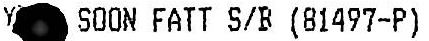

In [ ]:
data.x[0]

In [ ]:
data.y[0]

TextlineAndFont sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...

In [ ]:
data.y[0].data

(tensor([59,  1, 53, 49, 49, 48,  1, 40, 35, 54, 54,  1, 53, 17, 36,  1, 10, 26,
         19, 22, 27, 25, 15, 50, 11]), tensor(32))

### Learner

In [ ]:
#export
class CTCFontLoss(nn.Module):
    def __init__(self, ctc_pad_idx=0):
        super().__init__()
        self.ctc_loss = nn.CTCLoss(blank=ctc_pad_idx, reduction='mean', zero_infinity=True)
        self.metric_names = ['ctc_loss', 'font_loss']

    def _ctc_loss(self, y_pred, y_true, y_pred_len, y_true_len):
        # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
        b, s_e, c = y_pred.shape
#         print([len(x) for x in y_true], [len(x) for x in y_pred])
        y_true = torch.cat(y_true, axis=0) # [b*s_d]
        y_pred = y_pred.log_softmax(axis=2).permute(1,0,2) # [ s_e, b, c ]
        torch.backends.cudnn.enabled = False
        loss = self.ctc_loss(y_pred, y_true, y_pred_len, y_true_len)
        torch.backends.cudnn.enabled = True
        return loss
    
    def _font_loss(self, y_pred, y_true): # [b,c], [b]
        return nn.CrossEntropyLoss()(y_pred, y_true)
    
    def forward(self, nn_output, font_true, y_true, y_pred_len, y_true_len):
        font_pred, y_pred = nn_output
        ctc = self._ctc_loss(y_pred, y_true, y_pred_len, y_true_len)
        font = self._font_loss(font_pred, font_true)
        self.metrics = dict(zip(self.metric_names, [ctc, font]))
        return ctc + font

In [ ]:
#export
from fastai.callbacks import LossMetrics

class AddLossMetrics(LossMetrics):
    def on_batch_end(self, last_target, train, **kwargs):
        "Update the metrics if not `train`"
        if train: return
        bs = last_target[0].size(0) # CHANGED
        for name in filter(lambda n: n.endswith('loss'), self.names):
            self.metrics[name] += bs * self.learn.loss_func.metrics[name].detach().cpu()
        self.nums += bs

In [ ]:
#export
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]: d[i,j] = d[i-1,j-1]
            else: d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [ ]:
#export
def decode_true(texts): return texts

In [ ]:
#export
class WordErrorRate(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learner, decode_pred_func=decode_ctc, decode_true_func=decode_true):
        super().__init__(learner)
        self.classes = learner.data.classes
        self.decode_pred, self.decode_true = decode_pred_func, decode_true_func
        if not hasattr(self.learn.recorder, 'names'):
            self.learn.recorder.add_metric_names(['cer', 'wer'])
    
    def on_epoch_begin(self, **kwargs):
        self.wer, self.cer, self.total = 0, 0, 0
    
    def on_batch_end(self, last_output, last_target, train, **kwargs):
        if train: return
        font_pred, y_pred = last_output
        font_true, y_true, *_ = last_target
        y_pred = y_pred.argmax(-1)
        y_pred = self.decode_pred(y_pred)
        y_true = self.decode_true(y_true)
        for yp, yt in zip(y_pred, y_true):
            self.total += 1
            if yp.shape == torch.Size([]): continue
            yt_text = ''.join([self.classes[i] for i in yt])
            yp_text = ''.join([self.classes[i] for i in yp])
            self.wer += wer(yt_text.split(' '), yp_text.split(' '))
            self.cer += wer(yt_text, yp_text)
    
    def on_epoch_end(self, last_metrics, **kwargs):
        if self.total == 0: return {'last_metrics': last_metrics}
        metrics = [tensor(self.cer/self.total), tensor(self.wer/self.total)]
        return {'last_metrics': [last_metrics[0]] + metrics + last_metrics[1:]}

In [ ]:
# either load or create new learner
learner = load_inference('crnn_ocr')
learner.data = data
model = learner.model

In [ ]:
data = create_data(main_df, bs=8)
model = CRNN(nclass=data.c, fclass=len(data.font_classes))
loss_func = CTCFontLoss(ctc_pad_idx=data.classes.index(crnn_config.label_delim))
data

CNN output = h:3 c:256


ImageDataBunch;

Train: LabelList (37471 items)
x: MyImageList
Image (3, 48, 502),Image (3, 48, 756),Image (3, 48, 566),Image (3, 48, 348),Image (3, 48, 533)
y: TextlineList
sroie...Y` `S`O`O`N` `F`A`T`T` `S`/`B` `(`8`1`4`...,sroie...L`O`T` `1`5`0`4`,` `B`A`T`U` `8` `1`/`2`...,sroie...4`6`0`0`0` `P`E`T`A`L`I`N`G` `J`A`Y`A`,`...,sroie...T`E`L` `:` `0`1`6`-`2`0`1`4`2`0`9,sroie...G`S`T` `R`E`G` `N`O` `:` `0`0`0`7`8`8`2`...
Path: .;

Valid: LabelList (18440 items)
x: MyImageList
Image (3, 48, 272),Image (3, 48, 794),Image (3, 48, 432),Image (3, 48, 504),Image (3, 48, 355)
y: TextlineList
sroie...T`H`O`N`G` `R`E`C`I`P`E,sroie...1`6`G` `B`L`O`C`K` `B` `,`Z`E`N`I`T`H` `...,sroie...J`A`L`A`N` `S`S`7`/`2`6`,` `4`7`3`0`1,sroie...P`E`T`A`L`I`N`G` `J`A`Y`A` `S`E`L`A`N`G`...,sroie...T`E`L` `0`3`-`7`8`8`6` `4`8`7`7
Path: .;

Test: None

In [ ]:
# data.show_batch(figsize=(10,10))

In [ ]:
learner = Learner(data, model, loss_func=loss_func, callback_fns=[ShowGraph, AddLossMetrics, WordErrorRate])

epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.237106,0.246655,0.067450,0.290656,0.246655,0.000000,04:33


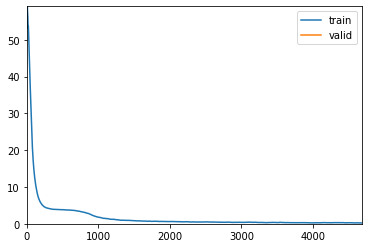

In [ ]:
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.246127,0.229327,0.062071,0.271613,0.229327,0.000000,04:34
1,0.224107,0.215609,0.058351,0.254724,0.215609,0.000000,04:34
2,0.193052,0.203882,0.056670,0.258322,0.203882,0.000000,04:34
3,0.162642,0.184741,0.049651,0.225425,0.184741,0.000000,04:32
4,0.136462,0.179144,0.051424,0.244269,0.179144,0.000000,04:34
5,0.146467,0.159553,0.042125,0.196718,0.159553,0.000000,04:34
6,0.132660,0.152502,0.041007,0.187542,0.152502,0.000000,04:36
7,0.142678,0.150065,0.038942,0.179972,0.150064,0.000000,04:34
8,0.115218,0.150122,0.039339,0.178554,0.150122,0.000000,04:34


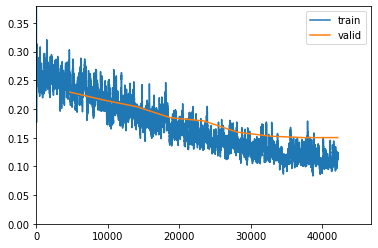

In [ ]:
learner.fit_one_cycle(15, 1e-4)

In [ ]:
save_inference(learner, 'crnn_ocr')

epoch,train_loss,valid_loss,cer,wer,ctc_loss,font_loss,time
0,0.068411,0.136059,0.033100,0.154314,0.136059,0.000000,04:33
1,0.082450,0.145006,0.035105,0.160422,0.145006,0.000000,04:35
2,0.080098,0.142361,0.034512,0.161418,0.142361,0.000000,04:35
3,0.074975,0.142947,0.034823,0.165454,0.142947,0.000000,04:35
4,0.060825,0.143260,0.034658,0.166857,0.143260,0.000000,04:35
5,0.072840,0.142390,0.035126,0.165453,0.142390,0.000000,04:36
6,0.054623,0.135100,0.032179,0.152955,0.135100,0.000000,04:34
7,0.080391,0.132901,0.032358,0.150744,0.132901,0.000000,04:34
8,0.056262,0.132906,0.031929,0.150359,0.132906,0.000000,04:34
9,0.043753,0.131469,0.031623,0.147909,0.131469,0.000000,04:35


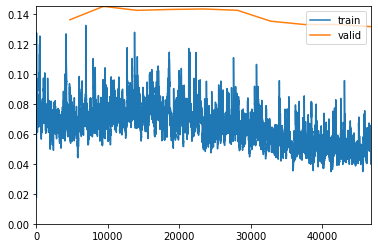

In [ ]:
learner.fit_one_cycle(10, 1e-4)

In [ ]:
save_inference(learner, 'crnn_ocr')

### Examples

In [ ]:
learner = load_inference('crnn_ocr')

In [ ]:
from pathlib import PosixPath
from ocr.core import *

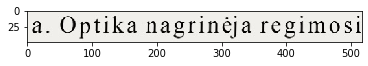

In [ ]:
im = cv2.imread(str(PosixPath('../data/ocr/fontsynth_lines/').ls()[0]))
plot(im)

In [ ]:
pred,_,_ = learner.predict( Image(tensor(im).permute(2,0,1) / 255.) )
chars, font = pred.obj
string = ''.join(chars)
string, font

('A. OPTIKA NA9RIMEJA RE9IMOSI', 'sroie2019')

### Eval

In [ ]:
def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)
    
    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue

    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [ ]:
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [ ]:
def idx2text(indexes):
    for i in indexes:
        try: data.classes[i]
        except: print('asd', i)
    return ''.join([data.classes[i] for i in indexes])

In [ ]:
def evaluate_model(model, dl, t2list=lambda t: list(t.cpu().numpy()), total=None):
    total = len(dl) if total is None else total
    errors = 0
    ps, rs, ws, cs = [], [], [], []
    for images, (font, texts, im_lens, text_lens) in tqdm(iter(dl), total=total):
        font_pred, y_pred = model(images)
        y_pred = y_pred.argmax(-1)
        pred_texts = decode_ctc(y_pred)
        for true_words, pred_words in zip(texts, pred_texts): # go through batch
            if list(pred_words.shape) == []:
#                 print('list(pred_words.shape) == []')
                errors += 1
                continue
            true_words, pred_words = t2list(true_words), t2list(pred_words)
            true_str, pred_str = idx2text(true_words), idx2text(pred_words)
            p,r = calc_precision_recall(true_words, pred_words)
            c = wer(true_str, pred_str)
            w = wer(true_str.split(' '), pred_str.split(' '))
            ps.append(p); rs.append(r); ws.append(w); cs.append(c)
    print('errors:', errors)
    return np.array(ps), np.array(rs), np.array(ws), np.array(cs)

# p, r, w, c = evaluate_model(learner.model.train(), data.valid_dl)

In [ ]:
model = learner.model.eval()

In [ ]:
p, r, w, c = evaluate_model(model, learner.data.train_dl)
c.mean(), w.mean(), p.mean(), r.mean()

In [ ]:
p, r, w, c = evaluate_model(model, learner.data.valid_dl)
c.mean(), w.mean(), p.mean(), r.mean()


errors: 12


(0.13151347572210367,
 0.5205015823554996,
 0.9309294784239218,
 0.8799421197150123)